# Setup

In [1]:
import nltk
import os
import time
import pandas as pd
import numpy as np
from pathlib import Path
from dataset import Dataset
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import load_model

from sklearn import metrics
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Dataset Load

690 lines skipped (not labeled)
0 lines skipped (not text)
Total filtered labels: 31
Text Length Max:  67
Text Length Min:  1
Text Length Mode: 6
Text Length Mean: 8.41
Text Length Std:  4.18
S/W Text Ratio:   8.41


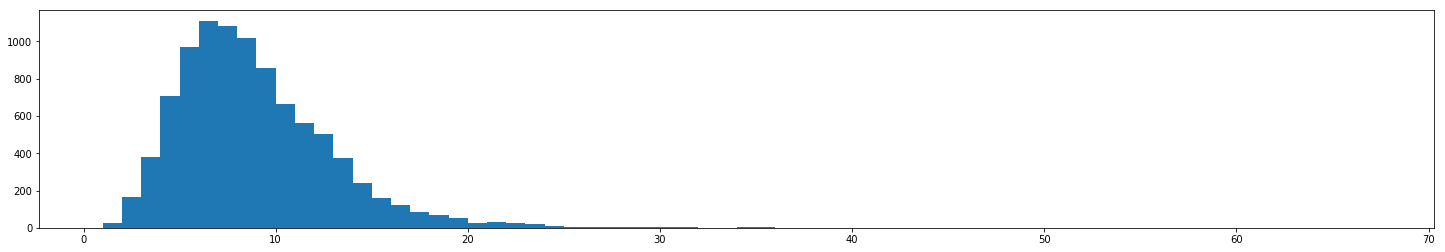

In [2]:
filename = 'datasets/amazon_co-ecommerce_sample.csv'
text_field ='name'

dataset = Dataset(filename)
dataset.load(text_field=text_field, label_field='category', root_label=True)
dataset.filer_data()
dataset.text_info()

# Preprocessing

In [3]:
tokenizer = dataset.tokenize()
label_encoder = dataset.label_encode()

Number of Tokens: 13022


In [4]:
data_train, data_test = train_test_split(dataset.data, test_size=0.15)
    
token_train = tokenizer.texts_to_sequences(data_train.text)
text_train = pad_sequences(token_train, maxlen=dataset.max_text())
label_train = label_encoder.transform(data_train.label)
        
token_test = tokenizer.texts_to_sequences(data_test.text)
text_test = pad_sequences(token_test, maxlen=dataset.max_text())
label_test = label_encoder.transform(data_test.label)

# Load Model

In [5]:
PATH_MODELS = 'created_models/'
MODEL = PATH_MODELS + 'sepcnn_100_name.h5'

In [6]:
model = load_model(MODEL)

/anaconda2/envs/CnnEnv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 67)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 67, 100)           1302300   
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 67, 64)            6764      
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 67, 64)            4352      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 31)                2015      
Total para

# Train Model

In [8]:
tensorboard = TensorBoard(log_dir="logs/" + model.name + '(' + time.asctime() + ')')

In [9]:
earlyStopping = EarlyStopping(monitor='val_acc', mode='auto',
                              min_delta=0.01, patience=5, restore_best_weights=True)

In [10]:
from keras.optimizers import RMSprop, Adam

optimizer = 'adam'

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [11]:
hist = model.fit(text_train, label_train, 
                 batch_size=64, epochs=60, initial_epoch=16,
                 verbose=1, callbacks=[earlyStopping, tensorboard],
                 validation_split=0.1)

Train on 7111 samples, validate on 791 samples
Epoch 17/60
7111/7111 [==============================] - 5s 660us/step - loss: 3.0239 - acc: 0.1200 - val_loss: 2.4930 - val_acc: 0.1820
Epoch 18/60
7111/7111 [==============================] - 4s 610us/step - loss: 2.4901 - acc: 0.1403 - val_loss: 2.4337 - val_acc: 0.1820
Epoch 19/60
7111/7111 [==============================] - 4s 610us/step - loss: 2.2574 - acc: 0.1911 - val_loss: 2.0407 - val_acc: 0.2693
Epoch 20/60
7111/7111 [==============================] - 4s 603us/step - loss: 1.9749 - acc: 0.2537 - val_loss: 1.8378 - val_acc: 0.3843
Epoch 21/60
7111/7111 [==============================] - 5s 655us/step - loss: 1.5869 - acc: 0.4282 - val_loss: 1.4053 - val_acc: 0.5259
Epoch 22/60
7111/7111 [==============================] - 4s 627us/step - loss: 1.1548 - acc: 0.5950 - val_loss: 1.2088 - val_acc: 0.6637
Epoch 23/60
7111/7111 [==============================] - 5s 647us/step - loss: 0.8529 - acc: 0.7363 - val_loss: 1.0735 - val_acc: 0

# Evaluation

### Metrics

In [12]:
ev_test  = model.evaluate(text_test, label_test, verbose=1)
label_pred = np.argmax(model.predict(text_test),axis=1)

1395/1395 [==============================] - 0s 99us/step


In [13]:
acc_tr   = hist.history['acc'][-1]
loss_tr  = hist.history['loss'][-1]
acc_val  = hist.history['val_acc'][-1]
loss_val = hist.history['val_loss'][-1]
acc_te   = ev_test[1]
loss_te  = ev_test[0]

print('Train)      Acc:', round((100*acc_tr),2),  'Loss:', round((loss_tr),3))
print('Validation) Acc:', round((100*acc_val),2), 'Loss:', round((loss_val),3))
print('Test)       Acc:', round((100*acc_te),2),  'Loss:', round((loss_te),3))

Train)      Acc: 95.42 Loss: 0.197
Validation) Acc: 75.47 Loss: 1.254
Test)       Acc: 71.11 Loss: 1.224


### Classification Report

**Precision** is the percentage of samples correctly predicted to that category<br>
P = tp / (tp + fp), tp = true positive, fp = false positive <br><br>

**Recall** is the percentage of samples of that category predicted correctly<br>
R    = tp / (tp + fn), tp = true positive, fn = false Negative <br><br>

In [14]:
class_report = metrics.classification_report(label_test, label_pred)
split = class_report.split('\n')
for i, line in enumerate(split):
    s = line.split()
    if len(s) > 0:
        support   = s[-1]
        s.pop()
        f1_score  = s[-1]
        s.pop()
        recall    = s[-1]
        s.pop()
        precision = s[-1]
        s.pop()
        if len(s) <= 0:
            label = 'label'
        else:
            label = ' '.join(s)
        split[i] = [label, precision, recall, f1_score, support]
    else:
        split[i] = ['']

df = pd.DataFrame(split)
df.columns = df.loc[0]
df = df.drop([0])
df = df.dropna()

/anaconda2/envs/CnnEnv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
print('Classification Report')
df[-10:]

Classification Report


,label,precision,recall,f1-score,support
17,19,0.00,0.00,0.00,2
18,21,0.00,0.00,0.00,1
19,22,0.90,0.84,0.87,97
20,23,0.00,0.00,0.00,2
21,24,0.00,0.00,0.00,8
22,25,0.89,0.77,0.82,43
23,26,0.52,0.53,0.53,73
25,micro avg,0.71,0.71,0.71,1395
26,macro avg,0.41,0.39,0.40,1395
27,weighted avg,0.71,0.71,0.71,1395


# Save Trained Model

In [16]:
# Save Model
model.save('trained_models/' + model.name + '.h5')